This notebook is made to observe the speed at which the target site gets populated.

In [3]:
using LinearAlgebra
using DifferentialEquations
using Plots
using DelimitedFiles
using SciMLBase # per terminate!
#using GR

# lo script per i conti senza oscillatori è identico, 
# ma con tutte le parti di codice riguardanti gli oscillatori rimosse 
# (ed i prodotti tensore ed il loro bagno termico)

const kb_unit_converter = 0.6950348
const cm_inv_to_eV_converter = 8065.544

commutator(a, b) = a*b - b*a
anticommutator(a,b) = a*b + b*a

limb_form(Operator, rho) = (Operator * rho * adjoint(Operator)) - 0.5 * anticommutator(adjoint(Operator) * Operator, rho)

n_temp = 200
temp_step = 50

temp = zeros(n_temp)

for i in 1:n_temp
    temp[i] = temp_step * i 
end

# costruisce un vettore per i valori gamma_load
# esponenziale fatto abbastanza ad occhio sulla base dei grafici
# di relazione tra gamma e V

final_currents = zeros(n_temp)

final_voltages = zeros(n_temp)

# inizializza vettori per le misure

# da qui costruisco base dei qbit
# e Hamiltoniana elettronica

n_qbit = 4

J = 100

qbit_basis = [zeros(ComplexF64, n_qbit) for _ in 1:n_qbit]            #Base nel sottospazio di singole eccitazioni

for i in 1:n_qbit
    qbit_basis[i][i] = 1.0
end         

E_i = ComplexF64[-10000, 300, 300, 0]

J_ij = [0 0 0 0
        0 0 J 0
        0 J 0 0
        0 0 0 0]                                                         #Coupling matrix editabile a mano

H_electronic =  zeros(ComplexF64, n_qbit, n_qbit)

for i in 1:n_qbit
    H_electronic[i, i] = E_i[i]
end

H_electronic = H_electronic + J_ij          

# Fine parte elettronica

D = 6                                                  #Troncamento dell'oscillatore armonico

I_ho = Matrix(I, D, D)                                 #Per comodità

I_qbit = Matrix(I, n_qbit, n_qbit)

omega = 200                                            #Frequenza dell'oscillatore armonico

ho_basis = [zeros(ComplexF64, D) for _ in 1:D]         #Base dell'oscillatore legato al qbit 2

for i in 1:D
    ho_basis[i][i] = 1.0
end

#ho_3_basis = ho_2_basis                               #La base ha la stessa forma

a = zeros(ComplexF64, D, D)

# operatore distruzione 

for i in 1:D-1
    a[i, i+1] = sqrt(i)
end

a_dagger = adjoint(a)                                  #Operatori creazione e distruzione degli oscillatori armonici

H_ho = omega * a_dagger * a                            #Hamiltoniana dell'oscillatore armonico

g2 = 55
g3 = 55                                                 #Coupling tra oscillatori e qbit

H_interaction = kron(qbit_basis[2] * adjoint(qbit_basis[2]), g2 * (a + a_dagger), I_ho) + 
                kron(qbit_basis[3] * adjoint(qbit_basis[3]), I_ho, g3 * (a + a_dagger))

H_tot = kron(H_electronic, I_ho, I_ho) +
        kron(I_qbit, H_ho, I_ho) +
        kron(I_qbit, I_ho, H_ho) +
        H_interaction

Hamiltonian(t) = H_tot


    ## Definisco le transizioni da 1 a 2

epsilon_1 = (qbit_basis[2] + qbit_basis[3])/sqrt(2)  # Speriamo bene

Transition_hot = kron(epsilon_1 * adjoint(qbit_basis[1]), I_ho, I_ho)

Transition_reverse_hot = kron(qbit_basis[1] * adjoint(epsilon_1), I_ho, I_ho)

Coeff_hot = 0.01 * 60000                                    # Presi dall'articolo (0.01 * 60 000)

Coeff_reverse_hot = 0.01 * (60000 + 1)

Limb_hot(rho) = Coeff_hot * limb_form(Transition_hot, rho) +
                Coeff_reverse_hot * limb_form(Transition_reverse_hot, rho)


## Definisco il bagno termico degli oscillatori armonici

Eccitation_ho2 = kron(I_qbit, a_dagger, I_ho)

Damping_ho2 = kron(I_qbit, a, I_ho)

Eccitation_ho3 = kron(I_qbit, I_ho, a_dagger)

Damping_ho3 = kron(I_qbit, I_ho, a)

#Temp_ho = 293

Population_ho(temperature_ho) = 1 / (exp(omega/ (kb_unit_converter * temperature_ho)) - 1)

Limb_ho(rho, temperature_ho) = 5.3 * (
            Population_ho(temperature_ho) * (limb_form(Eccitation_ho2, rho) + limb_form(Eccitation_ho3, rho)) +
            (Population_ho(temperature_ho) + 1) * (limb_form(Damping_ho2, rho) + limb_form(Damping_ho3, rho))
)

## Definisco il reservoir freddo 

Gamma_cold = 8.07
Temp_cold = 293

# parametri presi dall'articolo 

function limb_term(population, op, rev_op, rho)
    return population * limb_form(rev_op, rho) +
        (1 + population) * limb_form(op, rho)
end


populations = Float64[]
for_trans = Matrix{ComplexF64}[]
back_trans = Matrix{ComplexF64}[]

eigen_basis = copy(qbit_basis)

eigen_basis[2] = (qbit_basis[2] + qbit_basis[3])/sqrt(2)  
eigen_basis[3] = (qbit_basis[2] - qbit_basis[3])/sqrt(2)

eigen_energy = copy(E_i)

eigen_energy[2] = adjoint(eigen_basis[2]) * H_electronic * eigen_basis[2]
eigen_energy[3] = adjoint(eigen_basis[3]) * H_electronic * eigen_basis[3]

# eigen_energy, eigen_basis = eigen(H_electronic)  Lo faccio a mano che costa computazionalmente meno ma sticazziordered_eigen_energy = copy(eigen_energy)

ordered_eigen_energy = copy(eigen_energy)

ordered_eigen_energy[1] = eigen_energy[2]
ordered_eigen_energy[2] = eigen_energy[3]
ordered_eigen_energy[3] = eigen_energy[4]
ordered_eigen_energy[4] = eigen_energy[1]

ordered_eigen_basis = copy(eigen_basis)

ordered_eigen_basis[1] = eigen_basis[2]
ordered_eigen_basis[2] = eigen_basis[3]
ordered_eigen_basis[3] = eigen_basis[4]
ordered_eigen_basis[4] = eigen_basis[1]

# here we calculate the populations and the transition operators

for i in 1:n_qbit
    for j in (i + 1):n_qbit
        if i != j
            energy_diff = abs(ordered_eigen_energy[i] - ordered_eigen_energy[j])
            if energy_diff > 1e-9
                ij_population = 1 / (exp(energy_diff / (kb_unit_converter * Temp_cold)) - 1)
            else
                continue
            end

            Transition_forward = kron(ordered_eigen_basis[j] * adjoint(ordered_eigen_basis[i]), I_ho, I_ho)
            Transition_backward = kron(ordered_eigen_basis[i] * adjoint(ordered_eigen_basis[j]), I_ho, I_ho)
            
            push!(populations, ij_population)
            push!(for_trans, Transition_forward)
            push!(back_trans, Transition_backward)
        end
    end
end

# the Lindblad term is just the sum of all the transition operators and the populations

Limb_cold(rho) = Gamma_cold * sum(limb_term(populations[k], for_trans[k], back_trans[k], rho) for k in 1:length(populations))
#forward is the relaxation, backwards is the excitation

start_time = time_ns() # per comodità mia, misuro i tempi di calcolo

function Limb_load(rho, Gamma_load)
    Transition_load = kron(qbit_basis[1] * adjoint(qbit_basis[4]), I_ho, I_ho)
    return Gamma_load * limb_form(Transition_load, rho)
end

# definisco il temp finale

function Limb_tot(rho, Gamma_load, temperature_ho)
    # sommo tutti i termini di Limblad
    return Limb_hot(rho) + Limb_ho(rho, temperature_ho) + Limb_cold(rho) # + Limb_load(rho, Gamma_load)
end

function rho_primo(rho, p, t)
    Gamma_load = p[1] # è il valore di gamma_load
    temperature_ho = p[2]
    H_t = Hamiltonian(t)
    return 1im * commutator(rho, H_t) + Limb_tot(rho, Gamma_load, temperature_ho)
end

# definisco la condizione di stop per la simulazione

P_q1_full = kron(qbit_basis[1] * adjoint(qbit_basis[1]), I_ho, I_ho)
P_q4_full = kron(qbit_basis[4] * adjoint(qbit_basis[4]), I_ho, I_ho)

function steady_state_condition(rho, t, integrator)
    # prendo la derivata di rho
    drho = get_du(integrator)

    # calcolo la variazione delle popolazioni dei qbit
    pop_q1_rate = abs(real(tr(drho * P_q1_full)))
    pop_q4_rate = abs(real(tr(drho * P_q4_full)))

    # controllo se stiano cambiando sufficientemente o no
    #return max(pop_q1_rate, pop_q4_rate) < 1e-4
    return pop_q4_rate < 1e-10
end

# dichiaro che se non cambiano abbastanza la simulazione finisce
affect!(integrator) = terminate!(integrator)

# è il callback
cb = DiscreteCallback(steady_state_condition, affect!)

# ora definisco lo stato iniziale per la prima simulazione
# quelle dopo partiranno dallo stato finale dell'ultimo gamma provato
# per partire da qualcosa che dovrebbe essere vicino abbastanza all'equilibrio 


# Pre-allocate the power array
final_av2 = zeros(n_temp)
final_av3 = zeros(n_temp)
soltime = zeros(n_temp)

N_op_ho = a_dagger * a
N_op_ho2_full = kron(I_qbit, N_op_ho, I_ho)
N_op_ho3_full = kron(I_qbit, I_ho, N_op_ho)

ho_2_state = 1                                           #Eccitazione iniziale ho

rho0_ho_2 = ho_basis[ho_2_state] * adjoint(ho_basis[ho_2_state])

ho_3_state = 1                                           #Eccitazione iniziale ho

rho0_ho_3 = ho_basis[ho_3_state] * adjoint(ho_basis[ho_3_state])

excited_qbit = 1                                                      #Qbit eccitato a t=0

rho0_electronic = qbit_basis[excited_qbit] * adjoint(qbit_basis[excited_qbit])              #Matrice densità elettronica   

rho0 = kron(rho0_electronic, rho0_ho_2, rho0_ho_3)


current_t = 293 #carico gamma dal vettore 
current_gamma = 5000                                                                                    #CONSIDER INCREASING IT

p = (current_gamma, current_t)

tspan = (0.0, 0.3) #tempo massimo di simulazione se non viene fermata prima
prob = ODEProblem(rho_primo, rho0, tspan, p)
sol = solve(prob, Tsit5(), reltol = 1e-8, abstol = 1e-8)
rhof = sol[end] #rho finale (il secondo elemento della soluzione, dato che non salvo step intermedi)
endtime = sol.t[end]


current_av_ho2 = avg_N_ho2_t = real(tr(rhof * N_op_ho2_full))
current_av_ho3 = avg_N_ho3_t = real(tr(rhof * N_op_ho3_full))


    # --- 2. Append the latest data to files inside the loop ---
    
    # Append to VIP_data.csv
    #open("latest_timed_T/VIP_data.csv", "a") do io
        # Create a 1-row matrix for the new data and append it
    #    new_data_vip = [current_t  current_av_ho2 current_av_ho3]
    #    writedlm(io, new_data_vip, ',')
    #end

# Giusto per assicurarmi che il programma stia girando senza  problemi
    
    #global rho0 = rhof

# reinizializzo per la run successiva, così che la simulazione parta vicina all'equilibrio 

#final_powers = final_currents .* final_voltages

# da qui in avanti produco e salvo grafici e salvo dati su file csv

function partial_trace_A(rho::AbstractMatrix, n_A::Int, n_B::Int, n_C::Int)
    
    n_BC = n_B * n_C      # Dimension of the remaining B ⊗ C space
    n_total = n_A * n_BC

    # Sanity check
    if size(rho) != (n_total, n_total)
        error("rho matrix size ($(size(rho))) does not match total dimension ($n_total, $n_total)")
    end

    # This will be our resulting (B ⊗ C) matrix
    rho_BC = zeros(ComplexF64, n_BC, n_BC)
    
    # Identity on the (B ⊗ C) subspace
    I_BC = I(n_BC)

    # We perform the sum: Tr_A(rho) = Σ_i (<i|_A ⊗ I_BC) * rho * (|i>_A ⊗ I_BC)
    for i = 1:n_A
        # Create the <i|_A "bra" (row vector)
        bra_i_A = zeros(ComplexF64, 1, n_A)
        bra_i_A[i] = 1.0

        # Create the partial trace operator: <i|_A ⊗ I_BC
        op_i = kron(bra_i_A, I_BC)
        
        # Add this "slice" to the final matrix
        # op_i' is the "ket" operator |i>_A ⊗ I_BC
        rho_BC += op_i * rho * op_i'
    end
    
    return rho_BC
end

rho0_thermal_oscs = partial_trace_A(sol.u[end], n_qbit, D, D)

rho0 = kron(qbit_basis[1] * adjoint(qbit_basis[1]), rho0_thermal_oscs)

tspan = (0.0, 0.3) #tempo massimo di simulazione se non viene fermata prima
prob = ODEProblem(rho_primo, rho0, tspan, p)
sol = solve(prob, Tsit5(), reltol = 1e-8, abstol = 1e-8)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 277-element Vector{Float64}:
 0.0
 0.0003189669229618017
 0.0004614261422186809
 0.000705451784773171
 0.0009094293491926078
 0.0011572417430498537
 0.0014034969442053827
 0.0016755861937096236
 0.001959787263914642
 0.002266251390158798
 ⋮
 0.2919099213048516
 0.2930546837521449
 0.29419948618918695
 0.29534432820722073
 0.2964892093974472
 0.2976341292637573
 0.298779087484535
 0.2999240836508581
 0.3
u: 277-element Vector{Matrix{ComplexF64}}:
 [0.333888805159298 + 6.452829048028536e-17im -0.01815165947855266 - 0.0006081077965296639im … 0.0 - 0.0im 0.0 - 0.0im; -0.018151659478552688 + 0.000608107796529753im 0.1406456487657683 + 1.8080081421326078e-17im … -0.0 + 0.0im -0.0 + 0.0im; … ; -0.0 + 0.0im 0.0 - 0.0im … 0.0 + 0.0im 0.0 - 0.0im; -0.0 + 0.0im 0.0 - 0.0im … -0.0 + 0.0im 0.0 + 0.0im]
 [0.28091952004843807 + 5.425022498411009e-17im -0.015195872291022454 - 0.0014735262336674905im … 0.0 + 0.0im 0.0 + 0.0im

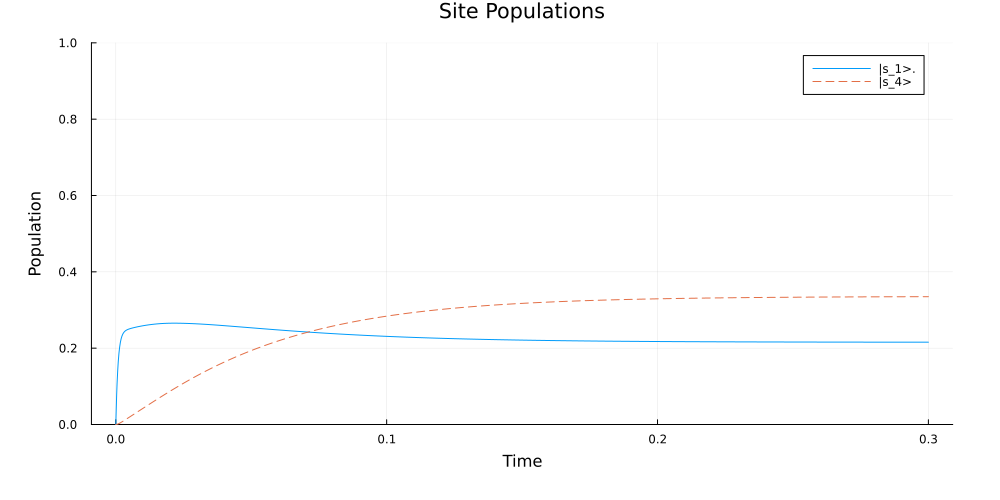

In [7]:
# Time points from the solution
times = sol.t

# 1. Qubit Populations
P_q2_full = kron(qbit_basis[3] * adjoint(qbit_basis[3]), I_ho, I_ho)
P_q3_full = kron(qbit_basis[4] * adjoint(qbit_basis[4]), I_ho, I_ho)
pop_q2_t = [real(tr(rho_t * P_q2_full)) for rho_t in sol.u]
pop_q3_t = [real(tr(rho_t * P_q3_full)) for rho_t in sol.u]
plot_qubit_pops = Plots.plot(times, pop_q2_t, label="|s_1>.", xlabel="Time", ylabel="Population", legend=:topright,  ylims=(0.0, 1.0))
plot!(plot_qubit_pops, times, pop_q3_t, label="|s_4>", linestyle=:dash)
title!(plot_qubit_pops, "Site Populations")



# MODIFIED: Final plot call with adjusted size and margins
plot_width = 1000
plot_height = 500 
Plots.plot(plot_qubit_pops,
           size=(plot_width, plot_height),
           linewidth=3,
           left_margin=10Plots.mm,
           bottom_margin=10Plots.mm,
           right_margin=10Plots.mm, # Ensure space for legends if they end up near right edge
           top_margin=5Plots.mm
          )

In [41]:
print(pop_q3_t[end])

0.33490637432175885

In [4]:
using LinearAlgebra
using DifferentialEquations
using Plots
using DelimitedFiles
using SciMLBase # per terminate!
#using GR

# lo script per i conti senza oscillatori è identico, 
# ma con tutte le parti di codice riguardanti gli oscillatori rimosse 
# (ed i prodotti tensore ed il loro bagno termico)

const kb_unit_converter = 0.6950348
const cm_inv_to_eV_converter = 8065.544

commutator(a, b) = a*b - b*a
anticommutator(a,b) = a*b + b*a

limb_form(Operator, rho) = (Operator * rho * adjoint(Operator)) - 0.5 * anticommutator(adjoint(Operator) * Operator, rho)

n_temp = 200
temp_step = 50

temp = zeros(n_temp)

for i in 1:n_temp
    temp[i] = temp_step * i 
end

# costruisce un vettore per i valori gamma_load
# esponenziale fatto abbastanza ad occhio sulla base dei grafici
# di relazione tra gamma e V

final_currents = zeros(n_temp)

final_voltages = zeros(n_temp)

# inizializza vettori per le misure

# da qui costruisco base dei qbit
# e Hamiltoniana elettronica

n_qbit = 4

J = 100

qbit_basis = [zeros(ComplexF64, n_qbit) for _ in 1:n_qbit]            #Base nel sottospazio di singole eccitazioni

for i in 1:n_qbit
    qbit_basis[i][i] = 1.0
end         

E_i = ComplexF64[-10000, 300, 300, 0]

J_ij = [0 0 0 0
        0 0 J 0
        0 J 0 0
        0 0 0 0]                                                         #Coupling matrix editabile a mano

H_electronic =  zeros(ComplexF64, n_qbit, n_qbit)

for i in 1:n_qbit
    H_electronic[i, i] = E_i[i]
end

H_electronic = H_electronic + J_ij          


H_tot = H_electronic

Hamiltonian(t) = H_tot


    ## Definisco le transizioni da 1 a 2

epsilon_1 = (qbit_basis[2] + qbit_basis[3])/sqrt(2)  # Speriamo bene

Transition_hot = epsilon_1 * adjoint(qbit_basis[1])

Transition_reverse_hot = qbit_basis[1] * adjoint(epsilon_1)

Coeff_hot = 0.01 * 60000                                    # Presi dall'articolo (0.01 * 60 000)

Coeff_reverse_hot = 0.01 * (60000 + 1)

Limb_hot(rho) = Coeff_hot * limb_form(Transition_hot, rho) +
                Coeff_reverse_hot * limb_form(Transition_reverse_hot, rho)



## Definisco il reservoir freddo 

Gamma_cold = 8.07
Temp_cold = 293

# parametri presi dall'articolo 

function limb_term(population, op, rev_op, rho)
    return population * limb_form(rev_op, rho) +
        (1 + population) * limb_form(op, rho)
end


populations = Float64[]
for_trans = Matrix{ComplexF64}[]
back_trans = Matrix{ComplexF64}[]

eigen_basis = copy(qbit_basis)

eigen_basis[2] = (qbit_basis[2] + qbit_basis[3])/sqrt(2)  
eigen_basis[3] = (qbit_basis[2] - qbit_basis[3])/sqrt(2)

eigen_energy = copy(E_i)

eigen_energy[2] = adjoint(eigen_basis[2]) * H_electronic * eigen_basis[2]
eigen_energy[3] = adjoint(eigen_basis[3]) * H_electronic * eigen_basis[3]

# eigen_energy, eigen_basis = eigen(H_electronic)  Lo faccio a mano che costa computazionalmente meno ma sticazziordered_eigen_energy = copy(eigen_energy)

ordered_eigen_energy = copy(eigen_energy)

ordered_eigen_energy[1] = eigen_energy[2]
ordered_eigen_energy[2] = eigen_energy[3]
ordered_eigen_energy[3] = eigen_energy[4]
ordered_eigen_energy[4] = eigen_energy[1]

ordered_eigen_basis = copy(eigen_basis)

ordered_eigen_basis[1] = eigen_basis[2]
ordered_eigen_basis[2] = eigen_basis[3]
ordered_eigen_basis[3] = eigen_basis[4]
ordered_eigen_basis[4] = eigen_basis[1]

# here we calculate the populations and the transition operators

for i in 1:n_qbit
    for j in (i + 1):n_qbit
        if i != j
            energy_diff = abs(ordered_eigen_energy[i] - ordered_eigen_energy[j])
            if energy_diff > 1e-9
                ij_population = 1 / (exp(energy_diff / (kb_unit_converter * Temp_cold)) - 1)
            else
                continue
            end

            Transition_forward = ordered_eigen_basis[j] * adjoint(ordered_eigen_basis[i])
            Transition_backward = ordered_eigen_basis[i] * adjoint(ordered_eigen_basis[j])
            
            push!(populations, ij_population)
            push!(for_trans, Transition_forward)
            push!(back_trans, Transition_backward)
        end
    end
end

# the Lindblad term is just the sum of all the transition operators and the populations

Limb_cold(rho) = Gamma_cold * sum(limb_term(populations[k], for_trans[k], back_trans[k], rho) for k in 1:length(populations))
#forward is the relaxation, backwards is the excitation

start_time = time_ns() # per comodità mia, misuro i tempi di calcolo

function Limb_load(rho, Gamma_load)
    Transition_load = qbit_basis[1] * adjoint(qbit_basis[4])
    return Gamma_load * limb_form(Transition_load, rho)
end

# definisco il temp finale

function Limb_tot(rho, Gamma_load, temperature_ho)
    # sommo tutti i termini di Limblad
    return Limb_hot(rho) + Limb_cold(rho) # + Limb_load(rho, Gamma_load)
end

function rho_primo(rho, p, t)
    Gamma_load = p[1] # è il valore di gamma_load
    temperature_ho = p[2]
    H_t = Hamiltonian(t)
    return 1im * commutator(rho, H_t) + Limb_tot(rho, Gamma_load, temperature_ho)
end

# definisco la condizione di stop per la simulazione

P_q1_full = qbit_basis[1] * adjoint(qbit_basis[1])
P_q4_full = qbit_basis[4] * adjoint(qbit_basis[4])

function steady_state_condition(rho, t, integrator)
    # prendo la derivata di rho
    drho = get_du(integrator)

    # calcolo la variazione delle popolazioni dei qbit
    pop_q1_rate = abs(real(tr(drho * P_q1_full)))
    pop_q4_rate = abs(real(tr(drho * P_q4_full)))

    # controllo se stiano cambiando sufficientemente o no
    #return max(pop_q1_rate, pop_q4_rate) < 1e-4
    return pop_q4_rate < 1e-10
end

# dichiaro che se non cambiano abbastanza la simulazione finisce
affect!(integrator) = terminate!(integrator)

# è il callback
cb = DiscreteCallback(steady_state_condition, affect!)

# ora definisco lo stato iniziale per la prima simulazione
# quelle dopo partiranno dallo stato finale dell'ultimo gamma provato
# per partire da qualcosa che dovrebbe essere vicino abbastanza all'equilibrio 


# Pre-allocate the power array
final_av2 = zeros(n_temp)
final_av3 = zeros(n_temp)
soltime = zeros(n_temp)

N_op_ho = a_dagger * a
N_op_ho2_full = kron(I_qbit, N_op_ho, I_ho)
N_op_ho3_full = kron(I_qbit, I_ho, N_op_ho)

ho_2_state = 1                                           #Eccitazione iniziale ho

rho0_ho_2 = ho_basis[ho_2_state] * adjoint(ho_basis[ho_2_state])

ho_3_state = 1                                           #Eccitazione iniziale ho

rho0_ho_3 = ho_basis[ho_3_state] * adjoint(ho_basis[ho_3_state])

excited_qbit = 1                                                      #Qbit eccitato a t=0

rho0_electronic = qbit_basis[excited_qbit] * adjoint(qbit_basis[excited_qbit])              #Matrice densità elettronica   

rho0 = rho0_electronic


current_t = 293 #carico gamma dal vettore 
current_gamma = 5000                                                                                    #CONSIDER INCREASING IT

p = (current_gamma, current_t)

tspan = (0.0, 0.3) #tempo massimo di simulazione se non viene fermata prima
prob = ODEProblem(rho_primo, rho0, tspan, p)
sol_without = solve(prob, Tsit5(), reltol = 1e-8, abstol = 1e-8)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 150-element Vector{Float64}:
 0.0
 0.00012922271496080962
 0.00018915854830630046
 0.0002870826466197219
 0.00037005012516394217
 0.0004673775608487629
 0.0005632856179618051
 0.000666008913815579
 0.000770948358241168
 0.0008804149583799399
 ⋮
 0.27829319624851506
 0.28116915694897404
 0.2840451183946963
 0.2869210803664869
 0.2897970430616215
 0.29267300648010036
 0.2955489706219236
 0.29842493526789604
 0.3
u: 150-element Vector{Matrix{ComplexF64}}:
 [1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im]
 [0.9282126358726028 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.035871365658330115 + 0.0im 0.03581008578627969 + 5.336271965144225e-19im 0.0 + 0.0im; 0.0 + 0.0im 0.03581008578627969 - 5.336271965144225e-19im 0.035871365658330115 + 0.0im 0.0 + 0.0im; 0

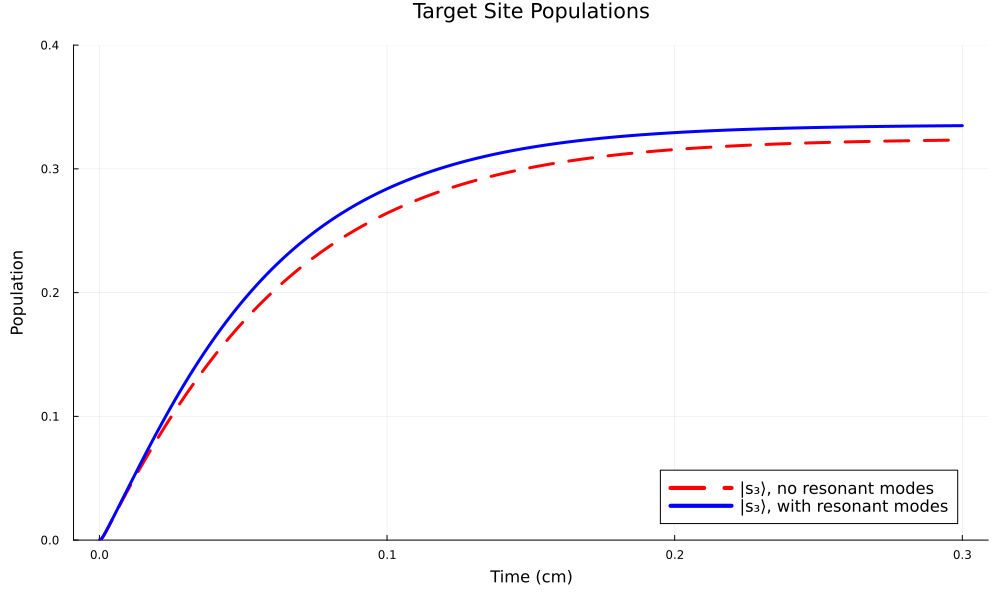

In [9]:
# Time points from the solution
times_without = sol_without.t

# 1. Qubit Populations
P_q2_full_without = qbit_basis[3] * adjoint(qbit_basis[3])
P_q3_full_without = qbit_basis[4] * adjoint(qbit_basis[4])
pop_q2_t_without = [real(tr(rho_t * P_q2_full_without)) for rho_t in sol_without.u]
pop_q3_t_without = [real(tr(rho_t * P_q3_full_without)) for rho_t in sol_without.u]
plot_qubit_pops = Plots.plot(times_without, pop_q3_t_without, label="|s₃⟩, no resonant modes", xlabel="Time (cm)", ylabel="Population", legend=:bottomright,  ylims=(0.0, 0.4), linewidth=3, linestyle=:dash, color=:red)
#plot!(plot_qubit_pops, times_without, pop_q3_t_without, label="|s_4>", linestyle=:dash)
plot!(plot_qubit_pops, times, pop_q3_t, label="|s₃⟩, with resonant modes", linewidth=3, color=:blue)
title!(plot_qubit_pops, "Target Site Populations")



# MODIFIED: Final plot call with adjusted size and margins
plot_width = 1000
plot_height = 600 
Plots.plot(plot_qubit_pops,
           size=(plot_width, plot_height),
           linewidth=3,
           legend_font_pointsize=11,
           left_margin=5Plots.mm,
           bottom_margin=5Plots.mm,
           #right_margin=10Plots.mm, # Ensure space for legends if they end up near right edge
           top_margin=5Plots.mm
          )

#display(plot_qubit_pops)